Days until 100k: 7.424630126436597


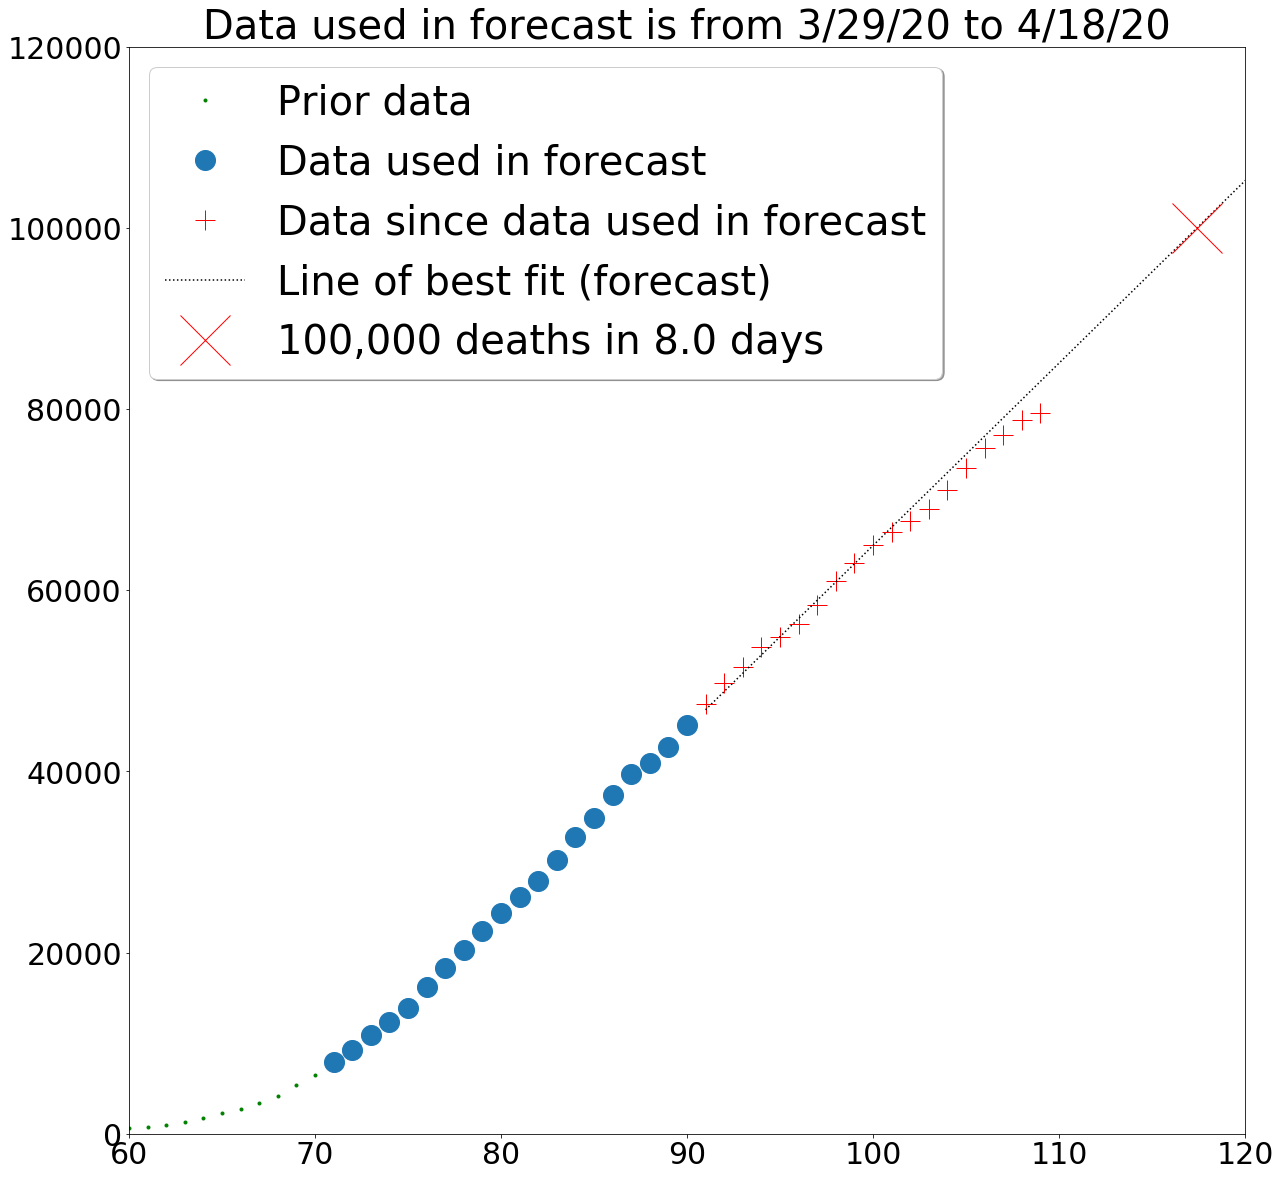

<Figure size 432x288 with 0 Axes>

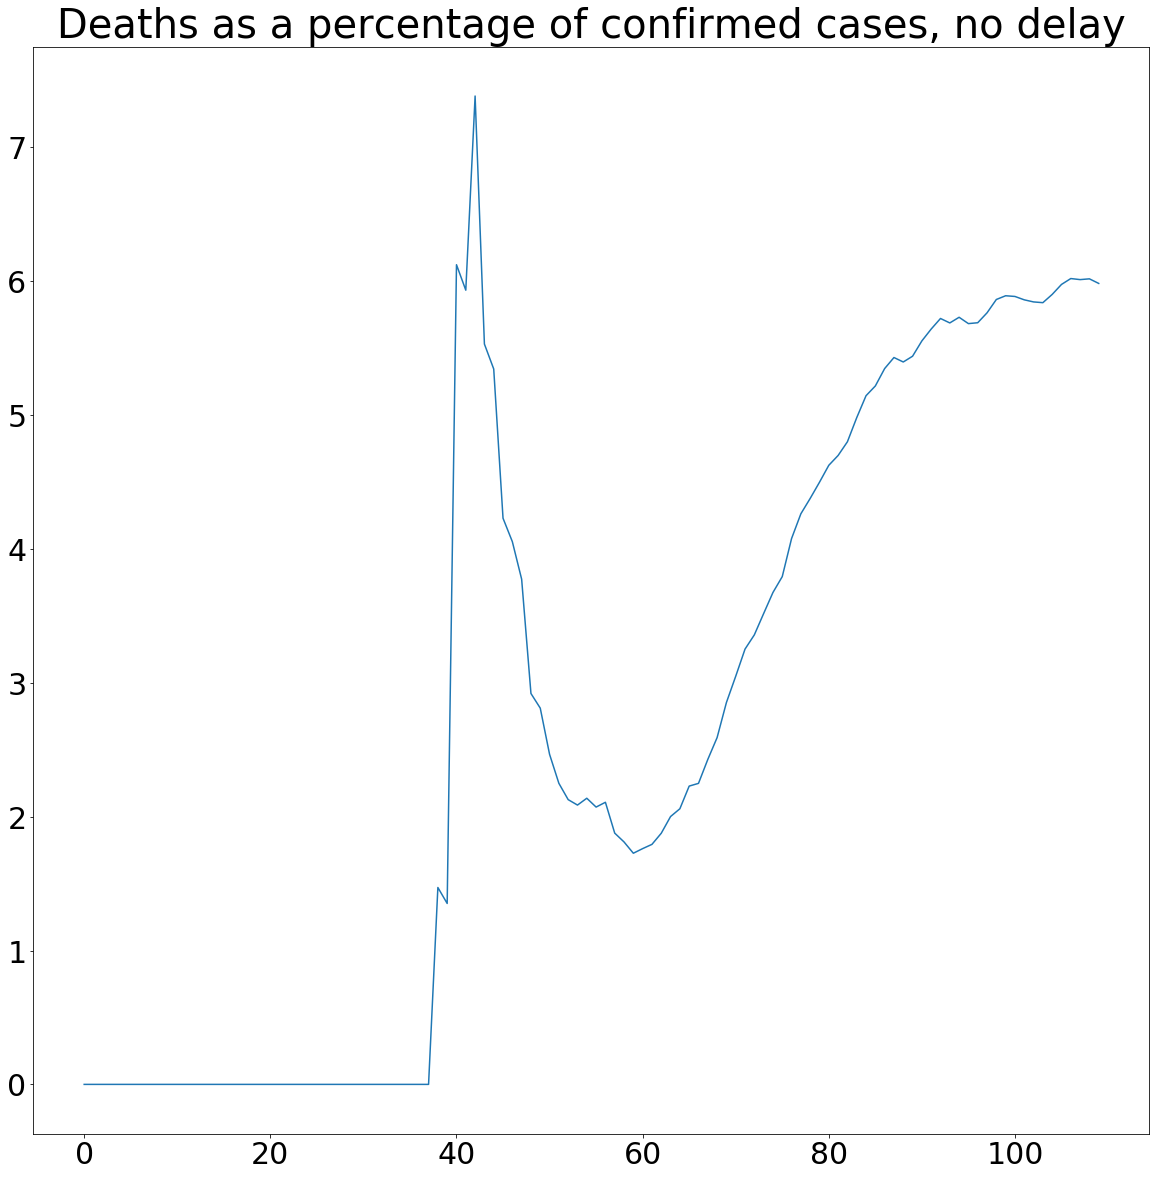

In [24]:
from numpy import log10, asarray, polyfit, ceil, arange
import csv
import matplotlib.pyplot as plt


def read_covid_data(data_type):
    if (data_type in ['confirmed', 'deaths', 'recovered']):
        COVID_directory = "/Users/kootsoop/git/COVID-19/csse_covid_19_data/csse_covid_19_time_series/"
        first_row = None
        with open(COVID_directory + 'time_series_covid19_' + data_type + '_global.csv') as csvfile:
            confirmed = csv.reader(csvfile)
            for row in confirmed:
                if (first_row == None):
                    first_row = row
                if (row[1] == 'US'):
                    us_data = row
                    break
    else:
        raise Exception('Invalid data_type', data_type)
    return(first_row, us_data)

(first_row, confirmed) = read_covid_data('confirmed')
(first_row2, recovered) = read_covid_data('recovered')
(first_row3, deaths) = read_covid_data('deaths')

# print(first_row[4:(len(first_row)-1)])
# print(deaths)
# print(str(len(first_row)) + ' ' \
#       +  str(len(confirmed))+ ' ' +  str(len(first_row2))+ ' ' +  str(len(recovered))+ ' ' \
#       +  str(len(first_row3))+ ' ' +  str(len(deaths)))

death_data = [(float(data)) for data in deaths[4:(len(first_row)-1)]]
recovered_data = [(float(data)) for data in recovered[4:(len(first_row)-1)]]
confirmed_data = [(float(data)) for data in confirmed[4:(len(first_row)-1)]]

first_row_shifted = [ data for data in first_row[4:(len(first_row)-1)]]
x_axis = arange(len(death_data))

# Started at 70 @ 2020/5/10
start_fit = 71
# Started 20 more than start_fit
end_fit = start_fit + 20
y_fit_data = death_data[start_fit:end_fit]
x_fit_data = arange(start_fit,end_fit)

y_pre = death_data[1:start_fit]
x_pre = arange(1,start_fit)


y_new_data = death_data[end_fit:len(death_data)]
x_new_data = arange(end_fit, len(death_data))

x_forecast = arange(end_fit, len(death_data) + 14)

[m, b] = polyfit(x_fit_data, y_fit_data, 1)

day_for_100k = (100000-b)/m


days_until = ceil(day_for_100k) - len(first_row_shifted) 

print('Days until 100k: ' + str(day_for_100k - len(first_row_shifted) ))

plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)

plt.figure(1)
plt.plot(x_pre, y_pre, 'g.', label='Prior data')
plt.plot(x_fit_data, y_fit_data,'o', markersize=20, label='Data used in forecast')
plt.plot(x_new_data, y_new_data,'r+',markersize=20,  label='Data since data used in forecast')
plt.plot(x_forecast, m*x_forecast + b,'k:',markersize=14,  label='Line of best fit (forecast)')
plt.plot(day_for_100k, 100000, 'rx', markersize=50, label='100,000 deaths in ' + str(days_until) + ' days')
plt.ylim(0,120000)
plt.xlim(60,120)
plt.title('Data used in forecast is from ' + first_row[start_fit] + ' to ' + first_row[end_fit], fontsize=40)
ax.legend(loc='upper left', shadow=True, fontsize=40)

plt.savefig('/Users/kootsoop/Pictures/COVID-19-FORECAST.png')

death_percent = [i / j * 100.0 for i, j in zip(death_data, confirmed_data)] 

plt.figure(2)
plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.plot(x_axis, death_percent)
plt.title('Deaths as a percentage of confirmed cases, no delay', fontsize=40)
plt.savefig('/Users/kootsoop/Pictures/COVID-19-DEATH-RATE.png')